## 2-pass LDA on all data & data with IT trends terms

In [25]:
import bz2
from collections import defaultdict
from datetime import datetime, timezone
import json
import logging
import os
import pickle
import re
import sys
import time

import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, HdpModel, LdaModel, LdaMulticore, Phrases, TfidfModel
from gensim.models.phrases import Phraser
from gensim.models.wrappers import ldamallet

# nltk
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

# Enable LDA viz
pyLDAvis.enable_notebook()
# Enable logging for gensim
logging.basicConfig(format='%(asctime)s: %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)

sys.path.append('../../../scripts-analytics/commonScripts/python/')

from database_connector import SQLConnector
from keys_handler import read_local_keys

In [26]:
HOME = os.environ['HOME']
KEYS = f'{HOME}/config/db.json'
ENV = 'dev'
NOW = datetime.now(timezone.utc)
TODAY = NOW.date()

DATA_DIR = '../data'
MODEL_DIR = '../model'
SQL_DIR = '../sql'
OUT_DIR = '../output'

DEV = True

In [27]:
if DEV:
    RUN_DATE = '2021-04-06'
else:
    RUN_DATE = str(TODAY)
RUN_DATE

'2021-04-06'

### Helper functions

In [28]:
# Pickle a file and then compress it into a file with extension 
def compress_pickle(filepath, data):
    with bz2.BZ2File(filepath + '.pbz2', 'w') as f: 
        pickle.dump(data, f)

In [29]:
# Load any compressed pickle file
def decompress_pickle(filepath):
    data = bz2.BZ2File(filepath, 'rb')
    data = pickle.load(data)
    return data

### Load data

1. IT trends terms (dataframe)
2. Clean comments (dataframe)
3. Preprocessed comments - grouped by title (dataframe)
4. Preprocessed comments with IT trends terms - grouped by title (dataframe)
5. Topic terms and data (dictionary, keys: terms, data)  - on all data
6. Topic terms and data (dictionary, keys: terms, data)  - on data with IT trends terms

In [30]:
# # IT trends terms
# it_trends_df = decompress_pickle(f'{DATA_DIR}/ittrends_terms_{RUN_DATE}.pkl.pbz2')

In [31]:
# print(it_trends_df.shape)
# it_trends_df.head()

In [32]:
# clean comments
comments_df = decompress_pickle(f'{DATA_DIR}/clean_data_{RUN_DATE}.pkl.pbz2')

In [33]:
print(comments_df.shape)
comments_df.head()

(495894, 4)


,comment,title,subreddit,score
0,bold assumption team capable throwing maintain...,building jenkins pipeline,devops,8
1,comparison sense jenkins actively developed ma...,building jenkins pipeline,devops,2
2,supports plugins recreate nightmare,building jenkins pipeline,devops,4
3,reading,building jenkins pipeline,devops,2
4,nailed progression upward forward interested l...,industries life devops,devops,2


In [34]:
uniqe_titles = comments_df.title.unique()
print(comments_df.title.unique())

['building jenkins pipeline' 'industries life devops'
 'starting kubernetes 101 livestream series youtube nov 18th' ...
 'helpdesk visual dashboard display solution'
 'companies pay cloud services pay subscription type'
 'proper systemd service responsibility']


In [35]:
comments_df['comment_len'] = comments_df.comment.apply(len)

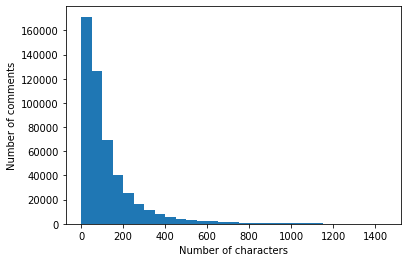

In [36]:
plt.hist(comments_df.comment_len.values, bins = range(0, 1500, 50))
plt.xlabel('Number of characters')
plt.ylabel('Number of comments')
plt.show()

In [37]:
# clean and preprocessed data having IT trends terms - grouped by title
data = decompress_pickle(f'{DATA_DIR}/grouped_titles_data_{RUN_DATE}.pkl.pbz2')

In [38]:
print(data.shape)
data.head()

(31734, 4)


,title,text,tokens,stem_text
0,,prepare artifacts push kind repository deploy...,"[prepare, artifacts, push, kind, repository, d...","[prepar, artifact, push, kind, repositori, dep..."
1,00 google hold notifications card google subs,00 google hold notifications card google subs ...,"[google, hold, notifications, card, google, su...","[googl, hold, notif, card, googl, sub, call, c..."
2,0365 email accounts,0365 email accounts block powershell access ad...,"[email, accounts, block, powershell, access, a...","[email, account, block, powershel, access, adm..."
3,0365 roll critical account protection accounts...,0365 roll critical account protection accounts...,"[roll, critical, account, protection, accounts...","[roll, critic, account, protect, account, high..."
4,06 secret history windows zipfolders original ...,06 secret history windows zipfolders original ...,"[secret, history, windows, zipfolders, origina...","[secret, histori, window, zipfold, origin, aut..."


In [39]:
# clean and preprocessed data and terms for each topic (from 1st pass) - data with IT trends terms
topic_terms_n_data = decompress_pickle(f'{DATA_DIR}/topic_terms_n_data_{RUN_DATE}.pkl.pbz2')

In [40]:
print(topic_terms_n_data[0]['terms'])

['password', 'email', 'account', 'mail', 'mfa', 'fa', 'authent', 'outlook', 'spam', 'phish', 'send', 'phone', 'address', 'spf', 'messag', 'gmail', 'login', 'sms', 'smtp', 'app']


In [41]:
print(topic_terms_n_data[0]['data'].shape)
topic_terms_n_data[0]['data'].head(2)

(21550, 4)


,title,text,tokens,stem_text
0,,prepare artifacts push kind repository deploy...,"[prepare, artifacts, push, kind, repository, d...","[prepar, artifact, push, kind, repositori, dep..."
1,0365 email accounts,0365 email accounts block powershell access ad...,"[email, accounts, block, powershell, access, a...","[email, account, block, powershel, access, adm..."


In [42]:
# # clean and preprocessed data and terms for each topic (from 1st pass) - data with IT trends terms
# topic_terms_n_data_ittrends = decompress_pickle(f'{DATA_DIR}/topic_terms_n_data_ittrends_{RUN_DATE}.pkl.pbz2')

In [43]:
# print(topic_terms_n_data_ittrends[5]['terms'])

In [20]:
# print(topic_terms_n_data_ittrends[0]['data'].shape)
# topic_terms_n_data_ittrends[0]['data'].head(2)

## Preprocessing

Note: Loaded data has been preprocessed - this is just for reference

### Tokenization


Tokenization is the process of breaking complex data (like paragraphs) into simple units called __tokens__

In [122]:
def tokenize(doc):
    for sentence in doc:
        yield(simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

### Remove stopwords

In [123]:
# stop_words = stopwords.words('english')
# len(stop_words)

179

In [124]:
# gist_file = f'{DATA_DIR}/gist_stopwords.txt'
# with open(gist_file, 'r') as f:
#     stop_words_from_file = f.read().split(',')

In [125]:
# stop_words.extend(stop_words_from_file)

In [126]:
# len(stop_words)

1768

In [127]:
# def remove_stopwords(doc):
#     return doc.apply(
#         lambda sent: [word for word in sent if word not in stop_words])

### Stemming
- Stemming is a normalization technique where list of tokenized words are converted into shorter root words called stems (note: stems are not always the root word)
- Drop last letter or prefix or suffix - may not produce meaningful words
- Stemming may reduce the accuracy of the model

In [128]:
def stemming(doc, stemmer_type):
    if stemmer_type=='port':
        stemmer = PorterStemmer()
    elif stemmer_type=='snow':
        stemmer = SnowballStemmer('english')
    stemmed_text = doc.apply(
            lambda sent: [stemmer.stem(word) for word in sent])
    return stemmed_text

### Lemmatization
- Lemmatization is the morphological analysis of the words - returning meaningful words
- Requires more disk space and processing time
- Leads to higher model accuaracy
- Root word is called __lemma__

In [129]:
# lemmatizer = WordNetLemmatizer()
# def lemmatization(doc):
#     return doc.apply(
#         lambda sent: [lemmatizer.lemmatize(word) for word in sent])

In [130]:
def preprocess(data):
    # Tokenize
    tokenized_text = list(tokenize(data.text))
    data['tokens'] = tokenized_text
    # # Remove stopwords
    # nostops_text = remove_stopwords(data.tokens)
    # # print('\nWithout stopwords:\n', nostops_text[1]) 
    # data['tokens'] = nostops_text # replace with clean tokenized
    print('\nTokenized:\n', data.tokens[1])
    # Snowball stemmer
    stemmed_text = stemming(data.tokens, 'snow')
    data['stem_text'] = stemmed_text
    print('\nStemmed:\n', stemmed_text[1])
    return data

In [131]:
# # already done
# # combine all comments under the same title - prepend title

comments_grouped_by_title = comments_df.groupby(['title'])
titles = list(comments_grouped_by_title.groups.keys())
title_comments = [
    f'{title} {" ".join(comments_grouped_by_title.get_group(title).comment)}'
    for title in titles]
data = pd.DataFrame({
    'title': titles,
    'text': title_comments})
data = preprocess(data)


Tokenized:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'credit', 'card', 'remember', 'straight', 'update', 'card', 'details', 'domain', 'registrars', 'report', 'card', 'lost', 'stolen', 'assume', 'compromised', 'testing', 'card']

Stemmed:
 ['googl', 'hold', 'notif', 'card', 'googl', 'sub', 'call', 'citibank', 'safe', 'wait', 'alert', 'suspici', 'plenti', 'disput', 'cancel', 'card', 'charg', 'today', 'odd', 'credit', 'card', 'rememb', 'straight', 'updat', 'card', 'detail', 'domain', 'registrar', 'report', 'card', 'lost', 'stolen', 'assum', 'compromis', 'test', 'card']


In [132]:
data.head()

,title,text,tokens,stem_text
0,,prepare artifacts push kind repository deploy...,"[prepare, artifacts, push, kind, repository, d...","[prepar, artifact, push, kind, repositori, dep..."
1,00 google hold notifications card google subs,00 google hold notifications card google subs ...,"[google, hold, notifications, card, google, su...","[googl, hold, notif, card, googl, sub, call, c..."
2,0365 email accounts,0365 email accounts block powershell access ad...,"[email, accounts, block, powershell, access, a...","[email, account, block, powershel, access, adm..."
3,0365 roll critical account protection accounts...,0365 roll critical account protection accounts...,"[roll, critical, account, protection, accounts...","[roll, critic, account, protect, account, high..."
4,06 secret history windows zipfolders original ...,06 secret history windows zipfolders original ...,"[secret, history, windows, zipfolders, origina...","[secret, histori, window, zipfold, origin, aut..."


In [133]:
# compress_pickle(f'{DATA_DIR}/grouped_titles_data_{RUN_DATE}.pkl', data)

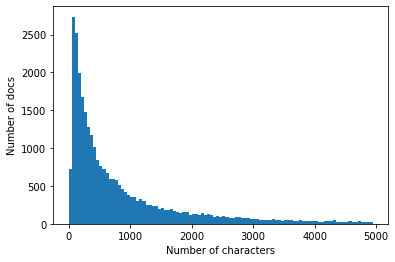

In [134]:
plt.hist(data.text.apply(len).values, bins = range(0, 5000, 50))
plt.xlabel('Number of characters')
plt.ylabel('Number of docs')
plt.show()

### Create dictionary, corpus and vectorized corpus needed for topic modeling

In [135]:
# Create dictionary representation of the documents
def build_corpus(doc, filter_extremes=True):
    doc_dict = corpora.Dictionary(doc)
    if filter_extremes:
        # Filter out words that occur in less than 20% documents, and above 50% documents
        doc_dict.filter_extremes(no_below=20, no_above=0.5)
    # Bag of words
    corpus = [doc_dict.doc2bow(text) for text in doc]
    # Compute TF-IDF score for each word in BoW (stemmed corpus)
    tfidf_mod = TfidfModel(corpus, normalize=True)
    vec_corpus = tfidf_mod[corpus]
    return doc_dict, corpus, vec_corpus, tfidf_mod

In [136]:
# Build stem corpus
(dict_stem,
 corpus_stem,
 vec_corpus_stem,
 tfid_stem_mod) = build_corpus(data.stem_text)

In [137]:
dict_stem[42]

'add'

## Topic Modeling

### Building the topic model

In [138]:
# Set training parameters.
num_topics = 7, # no. of subreddits
chunksize = 500
passes = 10
iterations = 500
eval_every = None # None - don't evaluate model perplexity, takes too much time.
workers = 6

# alpha and eta - affect sparsity of topics - defaults to 1.0/num_topics
# chunksize - control how many documents are processed at a time in training
# update_every - determined how often the parameters should be updated
# passes - total number of training passes
# iteration - control how often a particular loop is repeated over each document 
# eval_every - evaluate no. of passes and iterations
# workers - number of workers processes to be used for parallelization. 
#         - If None all available cores (as estimated by workers=cpu_count()-1 will be used

# Note - set passes and iterations high

In [139]:
# Print the keywords in the topics
def print_topics(model):
    for topic_num, words_in_topic in model.print_topics(-1):
        print(f'Topic {topic_num+1}:  Words: {words_in_topic}')

In [140]:
def print_coherence_score(model, corpus, dictionary, texts):
    # Compute Perplexity - lemmatized
    print(f'\n- Perplexity: {model.log_perplexity(corpus):.4f}')  # a measure of how good the model is. lower the better.
    # Compute Coherence Score using lemmatized comments
    coherence = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
    print(f'- Coherence Score: {coherence:.4f}')

In [141]:
# corpus - bow/tfidf dictionary of stemmed words

def build_lda(
    corpus, dictionary, corpus_type, num_topics, texts, chunksize=500, 
    passes=10, iterations=500, eval_every=None, workers=6):
    start = time.time()
    print(f'Building LDA model using {corpus_type} corpus'
          f' for {num_topics} topics...')
    mod = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=num_topics,
                       chunksize=chunksize,
                       passes=passes,
                       iterations=iterations,
                       workers=workers,
                       eval_every=eval_every)
    print(f' - {time.time()-start:.4f}s\n')
    print_topics(mod)
    print_coherence_score(mod, corpus, dictionary, texts)
    return mod

### 7 topics LDA - pass 1 - all data

In [142]:
# # 7 topic tfidf-stem corpus
# lda_tfidf_stem_7top_mod = build_lda(
#     corpus=vec_corpus_stem,
#     dictionary=dict_stem,
#     corpus_type='tfidf-stem',
#     texts=data.stem_text,
#     num_topics=7)

Building LDA model using tfidf-stem corpus for 7 topics...
 - 287.6351s

Topic 1:  Words: 0.043*"password" + 0.030*"email" + 0.014*"account" + 0.013*"mail" + 0.012*"mfa" + 0.011*"fa" + 0.009*"authent" + 0.008*"outlook" + 0.008*"spam" + 0.007*"phish"
Topic 2:  Words: 0.004*"secur" + 0.004*"compani" + 0.004*"job" + 0.003*"learn" + 0.003*"team" + 0.002*"manag" + 0.002*"cyber" + 0.002*"experi" + 0.002*"person" + 0.002*"start"
Topic 3:  Words: 0.007*"network" + 0.006*"vpn" + 0.006*"switch" + 0.006*"port" + 0.006*"server" + 0.006*"router" + 0.005*"connect" + 0.005*"dns" + 0.005*"firewal" + 0.005*"vlan"
Topic 4:  Words: 0.011*"code" + 0.009*"languag" + 0.008*"python" + 0.006*"program" + 0.005*"github" + 0.004*"write" + 0.004*"java" + 0.004*"compil" + 0.004*"librari" + 0.004*"develop"
Topic 5:  Words: 0.011*"whatsapp" + 0.011*"sysprep" + 0.007*"anydesk" + 0.006*"graphql" + 0.005*"telegram" + 0.005*"mitel" + 0.004*"mongodb" + 0.004*"adus" + 0.004*"ama" + 0.003*"vlc"
Topic 6:  Words: 0.012*"wind

In [144]:
# Save model
# compress_pickle(f'{MODEL_DIR}/lda_tfidf_stem_7top_mod_{RUN_DATE}.pkl', lda_tfidf_stem_7top_mod)

In [199]:
# # Load model
lda_tfidf_stem_7top_mod = decompress_pickle(f'{MODEL_DIR}/lda_tfidf_stem_7top_mod_{RUN_DATE}.pkl.pbz2')

In [200]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_7top_mod, vec_corpus_stem, dict_stem)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.022071 -0.033630       1        1  40.000713
6     -0.067852 -0.145520       2        1  17.254089
2     -0.087097  0.075220       3        1  16.412497
5     -0.099614  0.164109       4        1  11.633333
3     -0.113868 -0.055391       5        1   9.244598
0      0.226623  0.107746       6        1   3.427118
4      0.163878 -0.112535       7        1   2.027653, topic_info=            Term        Freq       Total Category  logprob  loglift
3103    password  405.000000  405.000000  Default  30.0000  30.0000
1378       email  337.000000  337.000000  Default  29.0000  29.0000
21       account  291.000000  291.000000  Default  28.0000  28.0000
4821      window  456.000000  456.000000  Default  27.0000  27.0000
766         code  377.000000  377.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
4036         soo    6.141897    9.306091   Topic7  -6.4755   3.4828
7999    workshop   12.081805   22.316811   Topic7  -5.7990   3.2847
6214      welcom    8.209208   13.800492   Topic7  -6.1854   3.3788
6827  sourceforg    6.237189    9.547131   Topic7  -6.4601   3.4726
4835    withdraw    5.433845    8.798594   Topic7  -6.5980   3.4163

[480 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
16        1  0.300950   access
16        2  0.032633   access
16        3  0.329957   access
16        4  0.250187   access
16        5  0.032633   access
...     ...       ...      ...
5597      2  0.950635      zen
5597      3  0.020226      zen
7118      5  0.922795      zig
9535      3  0.954423  zscaler
8890      5  0.882805      zsh

[1238 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 3, 6, 4, 1, 5])

In [150]:
# # to get topic terms and data only including topic terms - already done

def get_topic_terms_n_data(df, mod, num_topics, num_terms=20):      
    topic_terms_n_data = defaultdict(dict)
    for topic_id in range(num_topics):
        print('\n**\nTopic-id:', topic_id)
        # get topic terms
        topic_terms = [
            word for word, prob in mod.show_topic(topic_id, num_terms)]
        topic_terms_n_data[topic_id]['terms'] = topic_terms
        print('\nTop terms: ', topic_terms_n_data[topic_id]['terms'])
        # get topic comments using topic_terms
        mask = df.comment.apply(lambda x: any(term for term in topic_terms if term in x))
        topic_df = df[mask]
        # combine all topic comments under the same title - prepend title
        topic_df_grouped = topic_df.groupby(['title'])
        topic_titles = list(topic_df_grouped.groups.keys())
        title_comments = [
            f'{title} {" ".join(topic_df_grouped.get_group(title).comment)}'
            for title in topic_titles]
        topic_data = pd.DataFrame({
            'title': topic_titles,
            'text': title_comments})
        # preprocess comments
        topic_data = preprocess(topic_data)
        topic_terms_n_data[topic_id]['data'] = topic_data
    return topic_terms_n_data

In [151]:
# Perfrom LDA on topic data
sub_lda_corpus_n_mod_dict = {}
def build_sub_lda(topic_terms_n_data, num_top_topics, num_sub_topics, corpus_type):
    for topic_id in range(num_top_topics):
        print('\n**\nTop-level topic-id:', topic_id)
        print('\nTop terms: ', topic_terms_n_data[topic_id]['terms'])
        topic_text = topic_terms_n_data[topic_id]['data'].stem_text
        (topic_dict, corpus, 
         vec_corpus, tfid_mod) = build_corpus(topic_text, True)
        sub_lda_corpus_n_mod_dict[topic_id] = {
            'topic_dict': topic_dict,
            'corpus': corpus,
            'vec_corpus': vec_corpus,
            'texts': topic_text}
        if corpus_type=='tfidf-stem':
            sub_lda_corpus=vec_corpus
        elif corpus_type=='bow-stem':
            sub_lda_corpus=corpus
        print(f'\nCreating {num_sub_topics} topics...')
        sub_lda_corpus_n_mod_dict[topic_id]['mod'] = build_lda(
            corpus=sub_lda_corpus,
            dictionary=topic_dict,
            corpus_type=corpus_type,
            texts=topic_text,
            num_topics=num_sub_topics)
    return sub_lda_corpus_n_mod_dict

In [152]:
# topic_terms_n_data = get_topic_terms_n_data(comments_df, lda_tfidf_stem_7top_mod, 7, 20)


**
Topic-id: 0

Top terms:  ['password', 'email', 'account', 'mail', 'mfa', 'fa', 'authent', 'outlook', 'spam', 'phish', 'send', 'phone', 'address', 'spf', 'messag', 'gmail', 'login', 'sms', 'smtp', 'app']

Tokenized:
 ['email', 'accounts', 'block', 'powershell', 'access', 'admin', 'account', 'attackers', 'configuring', 'auto', 'forward', 'rules', 'mfa', 'defender', 'office', 'plan', 'add', 'users', 'phished', 'credential', 'stuffed', 'comprises', 'disable', 'legacy', 'enable', 'mfa', 'force', 'password', 'reset', 'implement', 'password', 'history', 'restriction', 'legacy', 'compromise', 'vectors']

Stemmed:
 ['email', 'account', 'block', 'powershel', 'access', 'admin', 'account', 'attack', 'configur', 'auto', 'forward', 'rule', 'mfa', 'defend', 'offic', 'plan', 'add', 'user', 'phish', 'credenti', 'stuf', 'compris', 'disabl', 'legaci', 'enabl', 'mfa', 'forc', 'password', 'reset', 'implement', 'password', 'histori', 'restrict', 'legaci', 'compromis', 'vector']

**
Topic-id: 1

Top term

In [153]:
# compress_pickle(f'{DATA_DIR}/topic_terms_n_data_{RUN_DATE}.pkl', topic_terms_n_data)

In [154]:
topic_terms_n_data[0]['data'][:2]

,title,text,tokens,stem_text
0,,prepare artifacts push kind repository deploy...,"[prepare, artifacts, push, kind, repository, d...","[prepar, artifact, push, kind, repositori, dep..."
1,0365 email accounts,0365 email accounts block powershell access ad...,"[email, accounts, block, powershell, access, a...","[email, account, block, powershel, access, adm..."


In [155]:
topic_terms_n_data[0]['data'].shape

(21550, 4)

In [156]:
print(topic_terms_n_data[0]['terms']) # security

['password', 'email', 'account', 'mail', 'mfa', 'fa', 'authent', 'outlook', 'spam', 'phish', 'send', 'phone', 'address', 'spf', 'messag', 'gmail', 'login', 'sms', 'smtp', 'app']


In [157]:
print(topic_terms_n_data[1]['terms']) # job & company  

['secur', 'compani', 'job', 'learn', 'team', 'manag', 'cyber', 'experi', 'person', 'start', 'day', 'cybersecur', 'work', 'engin', 'busi', 'data', 'network', 'softwar', 'question', 'cert']


In [158]:
print(topic_terms_n_data[2]['terms']) # networking

['network', 'vpn', 'switch', 'port', 'server', 'router', 'connect', 'dns', 'firewal', 'vlan', 'traffic', 'devic', 'rout', 'address', 'cisco', 'configur', 'isp', 'host', 'wifi', 'client']


In [159]:
print(topic_terms_n_data[3]['terms']) # programming

['code', 'languag', 'python', 'program', 'github', 'write', 'java', 'compil', 'librari', 'develop', 'project', 'rust', 'file', 'javascript', 'function', 'api', 'web', 'git', 'tool', 'script']


In [160]:
print(topic_terms_n_data[4]['terms']) # misc.

['whatsapp', 'sysprep', 'anydesk', 'graphql', 'telegram', 'mitel', 'mongodb', 'adus', 'ama', 'vlc', 'splashtop', 'workshop', 'dfsr', 'gam', 'mir', 'rife', 'ibb', 'displaynam', 'bandit', 'welcom']


In [161]:
print(topic_terms_n_data[5]['terms']) # sysadmin

['window', 'server', 'file', 'user', 'updat', 'instal', 'microsoft', 'backup', 'drive', 'domain', 'folder', 'gpo', 'log', 'powershel', 'admin', 'set', 'group', 'polici', 'machin', 'licens']


In [162]:
print(topic_terms_n_data[6]['terms']) # ML

['model', 'game', 'intel', 'gpu', 'paper', 'amd', 'perform', 'card', 'nvidia', 'train', 'cpu', 'power', 'core', 'price', 'imag', 'chip', 'dataset', 'learn', 'data', 'gb']


In [61]:
# # # # replace topic you think is not relevant with the last topic
# bad_topic_terms_n_data1 = topic_terms_n_data[4] 
# topic_terms_n_data[4] = topic_terms_n_data[6]

In [201]:
# print('irrelevant topic:', bad_topic_terms_n_data1['terms'])
# print('replaced by:', topic_terms_n_data[4]['terms'])

In [85]:
# bad_topic_terms_n_data2 = topic_terms_n_data[1]
# topic_terms_n_data[1] = topic_terms_n_data[5]

In [193]:
# print('irrelevant topic:', bad_topic_terms_n_data2['terms'])
# print('replaced by:', topic_terms_n_data[5]['terms'])

### 7 topic LDA - pass2 - all data

In [163]:
sub_lda_tfidf_stem_7top_7sub_dict = build_sub_lda(
    topic_terms_n_data, 
    7, # num top topics 
    7, # num sub topics
    'tfidf-stem') # corpus type


**
Top-level topic-id: 0

Top terms:  ['password', 'email', 'account', 'mail', 'mfa', 'fa', 'authent', 'outlook', 'spam', 'phish', 'send', 'phone', 'address', 'spf', 'messag', 'gmail', 'login', 'sms', 'smtp', 'app']

Creating 7 topics...
Building LDA model using tfidf-stem corpus for 7 topics...
 - 184.6253s

Topic 1:  Words: 0.009*"network" + 0.009*"switch" + 0.009*"router" + 0.008*"port" + 0.008*"vlan" + 0.007*"address" + 0.007*"rout" + 0.007*"traffic" + 0.007*"connect" + 0.007*"firewal"
Topic 2:  Words: 0.010*"autodiscov" + 0.008*"fax" + 0.007*"dism" + 0.006*"telegram" + 0.006*"cento" + 0.005*"pxe" + 0.004*"supermicro" + 0.004*"vss" + 0.004*"websocket" + 0.004*"sidebar"
Topic 3:  Words: 0.006*"intel" + 0.006*"amd" + 0.006*"game" + 0.005*"appl" + 0.005*"gpu" + 0.005*"card" + 0.005*"nvidia" + 0.005*"chip" + 0.005*"core" + 0.005*"power"
Topic 4:  Words: 0.007*"password" + 0.007*"lastpass" + 0.007*"tensorflow" + 0.007*"cnn" + 0.007*"techsupport" + 0.006*"spotifi" + 0.006*"aci" + 0.006*

In [164]:
# Save 2nd pass LDA results
# compress_pickle(f'{MODEL_DIR}/sub_lda_tfidf_stem_7top_7sub_dict_{RUN_DATE}.pkl', sub_lda_tfidf_stem_7top_7sub_dict)

In [165]:
# # Load 2nd pass LDA results
sub_lda_tfidf_stem_7top_7sub_dict = decompress_pickle(
    f'{MODEL_DIR}/sub_lda_tfidf_stem_7top_7sub_dict_{RUN_DATE}.pkl.pbz2')

In [166]:
print(topic_terms_n_data[0]['terms'])

['password', 'email', 'account', 'mail', 'mfa', 'fa', 'authent', 'outlook', 'spam', 'phish', 'send', 'phone', 'address', 'spf', 'messag', 'gmail', 'login', 'sms', 'smtp', 'app']


In [167]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_7top_7sub_dict[0]['mod'], 
    sub_lda_tfidf_stem_7top_7sub_dict[0]['vec_corpus'],
    sub_lda_tfidf_stem_7top_7sub_dict[0]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.011679 -0.023808       1        1  37.424301
5      0.154567  0.056768       2        1  19.558922
6      0.076334 -0.117842       3        1  14.910850
2     -0.018009 -0.126208       4        1  12.901086
0      0.129421  0.116566       5        1  11.035986
3     -0.185951  0.054512       6        1   2.136606
1     -0.168040  0.040011       7        1   2.032248, topic_info=          Term        Freq       Total Category  logprob  loglift
2181  password  313.000000  313.000000  Default  30.0000  30.0000
2615    router  140.000000  140.000000  Default  29.0000  29.0000
2011   network  295.000000  295.000000  Default  28.0000  28.0000
3313      vlan  122.000000  122.000000  Default  27.0000  27.0000
3398    window  348.000000  348.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
6114      year    7.326966   16.004568   Topic7  -5.9213   3.1147
6136       gpt   10.274321   28.825214   Topic7  -5.5832   2.8644
4766     oauth    6.253653   14.870174   Topic7  -6.0797   3.0298
4729      rhel    6.390914   15.715611   Topic7  -6.0580   2.9963
6291        uc    4.884698    9.608406   Topic7  -6.3268   3.2195

[445 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         2  0.921399      aad
12        1  0.215688   access
12        2  0.490199   access
12        3  0.044118   access
12        4  0.024510   access
...     ...       ...      ...
5249      5  0.900669    zebra
3919      4  0.916400      zen
3919      5  0.057275      zen
8215      5  0.948593  zscaler
7361      2  0.896746      zsh

[1074 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 7, 3, 1, 4, 2])

In [168]:
print(topic_terms_n_data[1]['terms'])

['secur', 'compani', 'job', 'learn', 'team', 'manag', 'cyber', 'experi', 'person', 'start', 'day', 'cybersecur', 'work', 'engin', 'busi', 'data', 'network', 'softwar', 'question', 'cert']


In [169]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_7top_7sub_dict[1]['mod'], 
    sub_lda_tfidf_stem_7top_7sub_dict[1]['vec_corpus'],
    sub_lda_tfidf_stem_7top_7sub_dict[1]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.011866 -0.062311       1        1  53.608849
5      0.091886 -0.042865       2        1  17.195742
3      0.063059  0.033893       3        1  11.291774
2      0.169877 -0.114212       4        1   9.247905
0     -0.236833 -0.139190       5        1   4.454933
6     -0.045863  0.171500       6        1   2.152967
1     -0.030260  0.153185       7        1   2.047830, topic_info=        Term        Freq       Total Category  logprob  loglift
3997  window  465.000000  465.000000  Default  30.0000  30.0000
3206  server  445.000000  445.000000  Default  29.0000  29.0000
3843    user  341.000000  341.000000  Default  28.0000  28.0000
3827   updat  261.000000  261.000000  Default  27.0000  27.0000
3175   secur  461.000000  461.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
4048    yaml   12.930088   34.382168   Topic7  -5.5001   2.9104
2023    land   11.585785   51.518940   Topic7  -5.6098   2.3962
1481     gcp    7.879540   23.606150   Topic7  -5.9954   2.7912
2687  plugin    7.904323   40.735390   Topic7  -5.9922   2.2487
1538     gpu    7.873221  111.084343   Topic7  -5.9962   1.2416

[450 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.166850       aad
0         5  0.778631       aad
5         1  0.148783  abstract
5         2  0.818308  abstract
14        1  0.835188    access
...     ...       ...       ...
4048      2  0.436273      yaml
4048      7  0.378103      yaml
4494      1  0.031952       zen
4494      3  0.958566       zen
6243      2  0.955957       zig

[1016 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 4, 3, 1, 7, 2])

In [170]:
print(topic_terms_n_data[2]['terms'])

['network', 'vpn', 'switch', 'port', 'server', 'router', 'connect', 'dns', 'firewal', 'vlan', 'traffic', 'devic', 'rout', 'address', 'cisco', 'configur', 'isp', 'host', 'wifi', 'client']


In [171]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_7top_7sub_dict[2]['mod'], 
    sub_lda_tfidf_stem_7top_7sub_dict[2]['vec_corpus'],
    sub_lda_tfidf_stem_7top_7sub_dict[2]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.030032  0.030901       1        1  42.822567
6     -0.096858  0.053136       2        1  15.597192
0      0.104416 -0.087272       3        1  11.878390
3     -0.146521  0.077312       4        1  10.181996
2     -0.151623 -0.144220       5        1   9.194376
4      0.100642  0.142135       6        1   8.136882
5      0.159913 -0.071993       7        1   2.188603, topic_info=              Term        Freq       Total Category  logprob  loglift
2274        router  210.000000  210.000000  Default  30.0000  30.0000
2888          vlan  176.000000  176.000000  Default  29.0000  29.0000
1897      password  200.000000  200.000000  Default  28.0000  28.0000
843          email  206.000000  206.000000  Default  27.0000  27.0000
2627        switch  299.000000  299.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
905           evpn   12.499715   17.586700   Topic7  -5.3808   3.4805
4233     spicework   11.584626   16.112911   Topic7  -5.4568   3.4920
133         arista   11.099368   17.609781   Topic7  -5.4996   3.3603
6735        netbox    9.648525   17.472931   Topic7  -5.6397   3.2281
3739  hyperparamet    8.191305   13.522097   Topic7  -5.8034   3.3207

[490 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
11        1  0.297514   access
11        2  0.251027   access
11        3  0.027892   access
11        4  0.218487   access
11        5  0.199892   access
...     ...       ...      ...
4198      1  0.082217  yubikey
4198      4  0.822172  yubikey
3537      3  0.951051      zen
5935      1  0.066548  zscaler
5935      2  0.931672  zscaler

[1265 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 1, 4, 3, 5, 6])

In [172]:
print(topic_terms_n_data[3]['terms'])

['code', 'languag', 'python', 'program', 'github', 'write', 'java', 'compil', 'librari', 'develop', 'project', 'rust', 'file', 'javascript', 'function', 'api', 'web', 'git', 'tool', 'script']


In [173]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_7top_7sub_dict[3]['mod'], 
    sub_lda_tfidf_stem_7top_7sub_dict[3]['vec_corpus'],
    sub_lda_tfidf_stem_7top_7sub_dict[3]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.036769 -0.072733       1        1  31.706120
4     -0.128291  0.026801       2        1  30.087498
6     -0.091998 -0.132354       3        1  21.764912
2     -0.162961  0.127328       4        1   9.277931
3      0.168485  0.066436       5        1   2.747997
0      0.135409 -0.003055       6        1   2.284815
1      0.116125 -0.012423       7        1   2.130732, topic_info=           Term        Freq       Total Category  logprob  loglift
1131     github  204.000000  204.000000  Default  30.0000  30.0000
1130        git  116.000000  116.000000  Default  29.0000  29.0000
88       ansibl   78.000000   78.000000  Default  28.0000  28.0000
1132     gitlab   69.000000   69.000000  Default  27.0000  27.0000
2959        vpn  131.000000  131.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2636  subreddit   14.482917   36.228580   Topic7  -5.1464   2.9318
114       april    5.910161   11.673337   Topic7  -6.0427   3.1681
3383        mod    6.413177   17.474419   Topic7  -5.9610   2.8463
270   bootstrap    5.590106   13.736711   Topic7  -6.0983   2.9496
883     english    6.958949   38.524044   Topic7  -5.8793   2.1375

[439 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
11        1  0.102610   access
11        2  0.570054   access
11        3  0.096909   access
11        4  0.228022   access
16        1  0.056099  account
...     ...       ...      ...
3058      4  0.030253      xml
4339      2  0.907695  yubikey
3488      1  0.950001      zen
3488      4  0.036538      zen
4358      6  0.936434      zig

[1024 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 7, 3, 4, 1, 2])

In [174]:
print(topic_terms_n_data[4]['terms'])

['whatsapp', 'sysprep', 'anydesk', 'graphql', 'telegram', 'mitel', 'mongodb', 'adus', 'ama', 'vlc', 'splashtop', 'workshop', 'dfsr', 'gam', 'mir', 'rife', 'ibb', 'displaynam', 'bandit', 'welcom']


In [175]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_7top_7sub_dict[4]['mod'], 
    sub_lda_tfidf_stem_7top_7sub_dict[4]['vec_corpus'],
    sub_lda_tfidf_stem_7top_7sub_dict[4]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.001594 -0.018630       1        1  71.125015
1     -0.137006  0.011395       2        1  14.069174
2     -0.003818 -0.111280       3        1   3.831945
6     -0.021381  0.068812       4        1   3.570173
4      0.058067  0.017339       5        1   2.542342
3      0.049857  0.026353       6        1   2.529088
0      0.052686  0.006011       7        1   2.332257, topic_info=          Term        Freq       Total Category  logprob  loglift
23      amazon  102.000000  102.000000  Default  30.0000  30.0000
1688     paper   37.000000   37.000000  Default  29.0000  29.0000
761   whatsapp   30.000000   30.000000  Default  28.0000  28.0000
392      learn   73.000000   73.000000  Default  27.0000  27.0000
632     server   74.000000   74.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
150      crack    1.232064    9.223279   Topic7  -6.4940   1.7453
474    network    1.682307   72.455887   Topic7  -6.1825  -0.0045
977        usb    1.456179   28.809284   Topic7  -6.3269   0.7735
52      backup    1.217123   27.160223   Topic7  -6.5062   0.6531
1137     secur    1.218080   77.772232   Topic7  -6.5054  -0.3982

[388 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2008      1  0.242390        ab
2008      3  0.484779        ab
3         1  0.493921    access
3         2  0.359215    access
3         4  0.044902    access
...     ...       ...       ...
2229      3  0.375848  workshop
2252      1  0.233212        xd
2252      3  0.233212        xd
2252      6  0.466423        xd
1114      1  0.933000       zen

[950 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 3, 7, 5, 4, 1])

In [176]:
print(topic_terms_n_data[5]['terms'])

In [192]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_7top_7sub_dict[5]['mod'], 
    sub_lda_tfidf_stem_7top_7sub_dict[5]['vec_corpus'],
    sub_lda_tfidf_stem_7top_7sub_dict[5]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.022857  0.022289       1        1  54.272087
0      0.183580 -0.041055       2        1  14.631839
5     -0.006554  0.128114       3        1  10.133830
1      0.183861 -0.066598       4        1   9.590531
2     -0.072159  0.182537       5        1   6.333642
4     -0.141725 -0.177132       6        1   2.834685
6     -0.169859 -0.048155       7        1   2.203388, topic_info=          Term        Freq       Total Category  logprob  loglift
2094  password  321.000000  321.000000  Default  30.0000  30.0000
922      email  251.000000  251.000000  Default  29.0000  29.0000
2236   printer  155.000000  155.000000  Default  28.0000  28.0000
15     account  233.000000  233.000000  Default  27.0000  27.0000
2235     print  123.000000  123.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
6024       gre    8.255010   13.367634   Topic7  -5.9009   3.3332
6337      puls    8.741289   15.256668   Topic7  -5.8436   3.2582
862     driver   18.497934  152.024597   Topic7  -5.0940   1.7088
3250  whatsapp   10.057536   32.162037   Topic7  -5.7034   2.6527
5064     index    8.821286   21.378933   Topic7  -5.8345   2.9299

[455 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         2  0.942675     aad
11        1  0.428130  access
11        2  0.298799  access
11        3  0.013379  access
11        4  0.254202  access
...     ...       ...     ...
4965      7  0.859153   zebra
3720      1  0.036540     zen
3720      3  0.950030     zen
3324      1  0.949772    zoom
3324      5  0.023744    zoom

[1043 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 6, 2, 3, 5, 7])

____

### 7 topics LDA - pass 1 - data having IT trends terms

In [177]:
# to select data having IT Trends terms

# get comments using ittrends terms
mask = comments_df.comment.apply(lambda x: any(term for term in it_trends_df.term if term in x))
data_w_terms_df = comments_df[mask]
# combine all comments under the same title - prepend title
data_w_terms_df_grouped = data_w_terms_df.groupby(['title'])
term_titles = list(data_w_terms_df_grouped.groups.keys())
title_comments = [
    f'{title} {" ".join(data_w_terms_df_grouped.get_group(title).comment)}'
    for title in term_titles] 
term_data = pd.DataFrame({
    'title': term_titles,
    'text': title_comments})
# preprocess comments
term_data = preprocess(term_data)

compress_pickle(f'{DATA_DIR}/grouped_comments_ittrends_{RUN_DATE}.pkl', term_data)


Tokenized:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'credit', 'card', 'remember', 'straight', 'update', 'card', 'details', 'domain', 'registrars', 'report', 'card', 'lost', 'stolen', 'assume', 'compromised', 'testing', 'card']

Stemmed:
 ['googl', 'hold', 'notif', 'card', 'googl', 'sub', 'call', 'citibank', 'safe', 'wait', 'alert', 'suspici', 'plenti', 'disput', 'cancel', 'card', 'charg', 'today', 'odd', 'credit', 'card', 'rememb', 'straight', 'updat', 'card', 'detail', 'domain', 'registrar', 'report', 'card', 'lost', 'stolen', 'assum', 'compromis', 'test', 'card']


In [178]:
(term_dict_stem, 
 term_corpus_stem,
 term_vec_corpus_stem,
 term_tfid_stem_mod) = build_corpus(term_data.stem_text)

In [179]:
# 7 topic tfidf-stem corpus
lda_tfidf_stem_7top_ittrends_mod = build_lda(
    corpus=term_vec_corpus_stem,
    dictionary=term_dict_stem,
    corpus_type='tfidf-stem',
    texts=term_data.stem_text,
    num_topics=7)

Building LDA model using tfidf-stem corpus for 7 topics...
 - 311.3487s

Topic 1:  Words: 0.010*"cento" + 0.008*"xss" + 0.005*"rhel" + 0.005*"hive" + 0.004*"jupyt" + 0.004*"ipynb" + 0.004*"minecraft" + 0.004*"owasp" + 0.004*"flask" + 0.004*"vba"
Topic 2:  Words: 0.039*"password" + 0.028*"email" + 0.015*"account" + 0.010*"mail" + 0.010*"phish" + 0.010*"spam" + 0.010*"fa" + 0.007*"phone" + 0.006*"messag" + 0.006*"link"
Topic 3:  Words: 0.006*"card" + 0.006*"intel" + 0.006*"game" + 0.005*"amd" + 0.005*"gpu" + 0.005*"power" + 0.005*"nvidia" + 0.005*"price" + 0.004*"perform" + 0.004*"cpu"
Topic 4:  Words: 0.012*"techsupport" + 0.011*"admx" + 0.010*"duo" + 0.004*"ftd" + 0.004*"pppoe" + 0.004*"qt" + 0.003*"activesync" + 0.003*"irb" + 0.003*"fex" + 0.003*"alphafold"
Topic 5:  Words: 0.005*"secur" + 0.005*"job" + 0.005*"compani" + 0.003*"cyber" + 0.003*"learn" + 0.003*"team" + 0.003*"cybersecur" + 0.003*"manag" + 0.003*"experi" + 0.003*"cert"
Topic 6:  Words: 0.007*"code" + 0.005*"languag" + 0.

In [194]:
# # Save model
compress_pickle(f'{MODEL_DIR}/lda_tfidf_stem_7top_ittrends_mod_{RUN_DATE}.pkl', lda_tfidf_stem_7top_ittrends_mod)

In [181]:
# # Load model
# lda_tfidf_stem_7top_ittrends_mod = decompress_pickle(f'{MODEL_DIR}/lda_tfidf_stem_7top_ittrends_mod_{RUN_DATE}.pkl.pbz2')

In [182]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_7top_ittrends_mod, term_vec_corpus_stem, term_dict_stem)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.114826  0.106220       1        1  33.016731
4      0.078874  0.035403       2        1  27.957371
5      0.115611  0.002591       3        1  18.860111
2      0.114909 -0.110247       4        1  12.697422
1     -0.170879  0.156913       5        1   3.448914
0     -0.128404 -0.099464       6        1   2.023037
3     -0.124937 -0.091417       7        1   1.996417, topic_info=             Term        Freq       Total Category  logprob  loglift
3052     password  369.000000  369.000000  Default  30.0000  30.0000
1355        email  311.000000  311.000000  Default  29.0000  29.0000
21        account  284.000000  284.000000  Default  28.0000  28.0000
3764        secur  459.000000  459.000000  Default  27.0000  27.0000
3118        phone  202.000000  202.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
4249  techsupport   46.613373   81.957886   Topic7  -4.4106   3.3495
7242         drum    5.192564    8.578281   Topic7  -6.6052   3.4118
7231       fusion    6.497484   11.689617   Topic7  -6.3810   3.3265
2600        mcafe    6.240661   16.539738   Topic7  -6.4214   2.9391
5544          tac    5.682085   16.353354   Topic7  -6.5151   2.8567

[447 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6         1  0.041327  abstract
6         2  0.061990  abstract
6         3  0.867860  abstract
16        1  0.714329    access
16        2  0.161300    access
...     ...       ...       ...
5483      4  0.946840       zen
6975      3  0.959760       zig
9334      1  0.958030   zscaler
4822      1  0.437895     zyxel
4822      6  0.517512     zyxel

[1065 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 6, 3, 2, 1, 4])

In [204]:
topic_terms_n_data_ittrends = get_topic_terms_n_data(comments_df, lda_tfidf_stem_7top_ittrends_mod, 7, 20)


**
Topic-id: 0

Top terms:  ['cento', 'xss', 'rhel', 'hive', 'jupyt', 'ipynb', 'minecraft', 'owasp', 'flask', 'vba', 'wsl', 'banner', 'ama', 'zyxel', 'wordpress', 'headless', 'selenium', 'cheatsheet', 'xilinx', 'cve']

Tokenized:
 ['amd', 'gpus', 'pro', 'pro', 'step', 'build', 'bought', 'hardware', 'ghz', 'celeron', 'geforce', 'fx', 'ofcourse', 'disappointed', 'performance', 'decided', 'sell', 'extra', 'hours', 'job', 'dish', 'washing', 'summer', 'dishwashing', 'bought', 'athlon', 'xp', 'radeon', 'pro', 'working', 'nvidia', 'nforce', 'chipset', 'amazed', 'crank', 'settings', 'play', 'smooth', 'fps', 'bios', 'flash', 'pro', 'recall', 'correctly', 'prices', 'high', 'cpu', 'gpu', 'times', 'buy', 'hardware']

Stemmed:
 ['amd', 'gpus', 'pro', 'pro', 'step', 'build', 'bought', 'hardwar', 'ghz', 'celeron', 'geforc', 'fx', 'ofcours', 'disappoint', 'perform', 'decid', 'sell', 'extra', 'hour', 'job', 'dish', 'wash', 'summer', 'dishwash', 'bought', 'athlon', 'xp', 'radeon', 'pro', 'work', 'nvidi

In [205]:
compress_pickle(f'{DATA_DIR}/topic_terms_n_data_ittrends_{RUN_DATE}.pkl', topic_terms_n_data_ittrends)

In [206]:
print(topic_terms_n_data_ittrends[0]['terms'])

['cento', 'xss', 'rhel', 'hive', 'jupyt', 'ipynb', 'minecraft', 'owasp', 'flask', 'vba', 'wsl', 'banner', 'ama', 'zyxel', 'wordpress', 'headless', 'selenium', 'cheatsheet', 'xilinx', 'cve']


In [207]:
print(topic_terms_n_data_ittrends[1]['terms'])

['password', 'email', 'account', 'mail', 'phish', 'spam', 'fa', 'phone', 'messag', 'link', 'googl', 'address', 'spf', 'hack', 'send', 'scam', 'breach', 'login', 'compromis', 'gmail']


In [208]:
print(topic_terms_n_data_ittrends[2]['terms'])

['card', 'intel', 'game', 'amd', 'gpu', 'power', 'nvidia', 'price', 'perform', 'cpu', 'chip', 'laptop', 'core', 'gb', 'buy', 'hardwar', 'appl', 'cabl', 'nm', 'ram']


In [209]:
print(topic_terms_n_data_ittrends[3]['terms'])

['techsupport', 'admx', 'duo', 'ftd', 'pppoe', 'qt', 'activesync', 'irb', 'fex', 'alphafold', 'fmc', 'bookstack', 'nordvpn', 'tcam', 'imessag', 'lmgtfi', 'es', 'recap', 'openldap', 'nb']


In [210]:
print(topic_terms_n_data_ittrends[4]['terms'])

['secur', 'job', 'compani', 'cyber', 'learn', 'team', 'cybersecur', 'manag', 'experi', 'cert', 'engin', 'devop', 'start', 'person', 'interview', 'skill', 'degre', 'day', 'work', 'busi']


In [211]:
print(topic_terms_n_data_ittrends[5]['terms'])

['code', 'languag', 'model', 'paper', 'learn', 'python', 'program', 'data', 'write', 'github', 'project', 'train', 'imag', 'function', 'dataset', 'video', 'librari', 'articl', 'compil', 'develop']


In [212]:
print(topic_terms_n_data_ittrends[6]['terms'])

['server', 'window', 'user', 'file', 'updat', 'network', 'connect', 'instal', 'devic', 'switch', 'vpn', 'microsoft', 'domain', 'set', 'access', 'port', 'log', 'servic', 'router', 'dns']


####  All topics look relevant - no topic was replaced

### 7 topic LDA - pass2 - data having IT trends terms

In [ ]:
# sub_lda_tfidf_stem_7top_7sub_ittrends_dict = build_sub_lda(
#     topic_terms_n_data_ittrends, 
#     7, # num top topics
#     7, # num sub topics
#     'tfidf-stem') # corpus type

In [ ]:
# # Save 2nd pass LDA results
# compress_pickle(f'{MODEL_DIR}/sub_lda_tfidf_stem_7top_7sub_ittrends_dict_{RUN_DATE}.pkl', sub_lda_tfidf_stem_7top_7sub_ittrends_dict)

In [ ]:
# # Load 2nd pass LDA results
# sub_lda_tfidf_stem_7top_7sub_ittrends_dict = decompress_pickle(f'{MODEL_DIR}/sub_lda_tfidf_stem_7top_7sub_ittrends_dict_{RUN_DATE}.pkl.pbz2')

In [ ]:
# print(topic_terms_n_data_ittrends[0]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[0]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[0]['vec_corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[0]['topic_dict'])
# viz

In [ ]:
# print(topic_terms_n_data_ittrends[1]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[1]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[1]['vec_corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[1]['topic_dict'])
# viz

In [ ]:
# print(topic_terms_n_data_ittrends[2]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[2]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[2]['corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[2]['topic_dict'])
# viz

In [ ]:
# print(topic_terms_n_data_ittrends[3]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[3]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[3]['vec_corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[3]['topic_dict'])
# viz

In [ ]:
# print(topic_terms_n_data_ittrends[4]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[4]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[4]['corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[4]['topic_dict'])
# viz

In [ ]:
# print(topic_terms_n_data_ittrends[5]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[5]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[5]['vec_corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[5]['topic_dict'])
# viz

In [ ]:
# print(topic_terms_n_data_ittrends[6]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[6]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[6]['vec_corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[6]['topic_dict'])
# viz